In [1]:
#Cold dipole solution with grad(phi) = 0 at the coil  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import Dipole_Tools as dt
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix, linalg as sla
from scipy.interpolate import RectBivariateSpline, interp1d
from numba import jit, njit, prange
from matplotlib import rc
rc('text',usetex=True)

In [3]:
#Set-up of the grid according to the traps geometry, the boundary conditions and natural constants
#Apex config
R_coil = 15.3/2  #coil radius APEX trap
dR_coil = 2.1 
R_wall = 3*R_coil #20 
H = 2*R_coil #13 

c = 2.99e10 #Speed of light
e = 1.602e-20*c #elementary charge
q = -e #electron charge
me = 9.109e-28 #electron mass

#B0 = 1 #Magnetic field B(r=0, z=0) due to the inner coil in Tesla
I = 54e3*0.1*c #Current in the inner coil of APEX Trap
T0 = 1e7*1.602e-19 #Plasma temperature (1 eV in erg)
omega = 1e6 #Rotation frequency in rad/s
N0 = 1e10 #Total Number of particles

res_r = 3000 # Radial number of grid points
res_z = 1000 # Longitudinal number of grid points

filename_load = 'LTE2GTE'
filename_save = 'LTE2GTE'

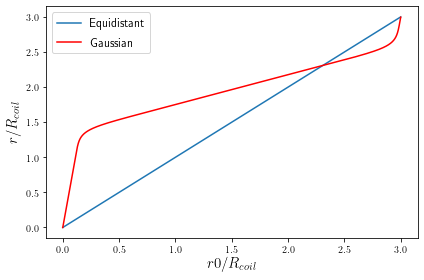

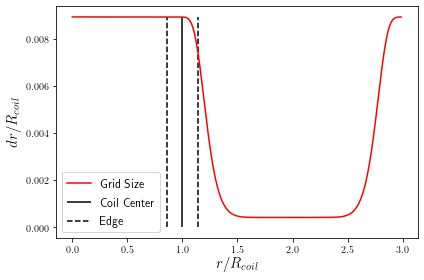

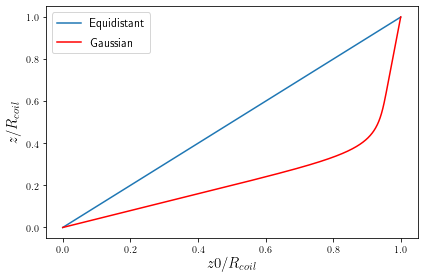

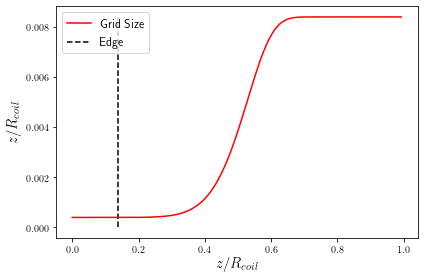

0.0032474250000000004 0.003060000000000143


In [4]:
def spacing_r(r, dr, R_wall, R_coil, res_r):
    
    sigma_dr = (R_wall-R_coil)/2.5#Width of the gaussian
    #APEX
    dr0 = 2.68*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    #Cold
    dr0 = 8.49*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    #Matt
    #dr0 = 2.85*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    dr_min = dr0*0.05 #Minimal Distance of two grid points
    R_exp = (R_wall+R_coil)/2 #Maxima of the super-gaussian = minima in grid spacing
    exp_r = 10
    
    if len(dr) == 0:
        dr = 2*[dr0+dr_min]
        r = [R_wall, R_wall-dr0]
    dr_i = 2*dr[-1] - dr[-2] #of the next grid point to calculate the corresponding spacing
    dr.append(dr0*(1-np.exp(-(r[-1]-dr[-1]-R_exp)**exp_r/(sigma_dr**exp_r)))+dr_min) #and I need the spacing
    r.append(r[-1]-dr[-1])
    
    return r, dr

def spacing_z(z, dz, R_coil, H, res_z):
    
    #APEX
    #sigma_dz = H/3
    #dz0 = 11.1*H/res_z
    #dz_min = 0.02*dz0
    #Cold
    sigma_dz = H/4
    dz0 = 4*H/res_z
    dz_min = 0.05*dz0
    exp_z = 8

    if len(dz) == 0:
        dz = 2*[dz0+dz_min]
        z = [H/2, H/2-dz0]
    dz_i = 2*dz[-1] - dz[-2]
    dz.append(dz0*(1-np.exp(-(z[-1]-dz[-1])**exp_z/(2*sigma_dz**exp_z)))+dz_min)
    z.append(z[-1]-dz[-1])
        
    return z, dz

r, z, dr, dz, r0, z0 = dt.grid(R_coil, R_wall, H, res_r, res_z, spacing_r, spacing_z, 0)
show = dt.check_grid(r, z, r0, z0, R_coil, dR_coil, dr, dz, res_r, res_z)
print(np.min(dr), np.min(dz))

In [5]:
filename_load = 'GTE'
f_gte = np.loadtxt(filename_load+'_T'+str(round(0.5, 2))+'distribution.txt')
f_interp = RectBivariateSpline(r, z, f_gte)

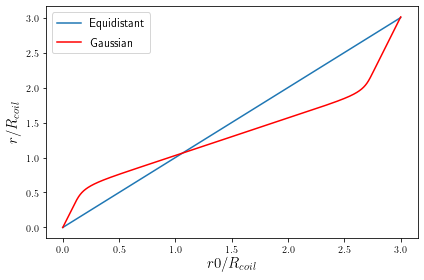

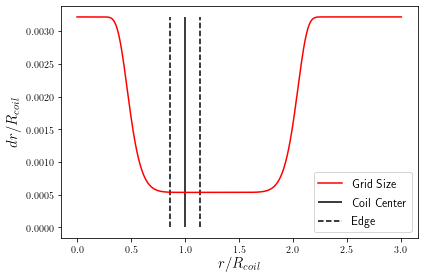

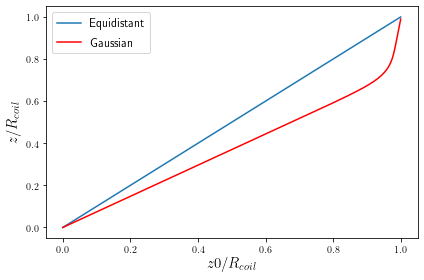

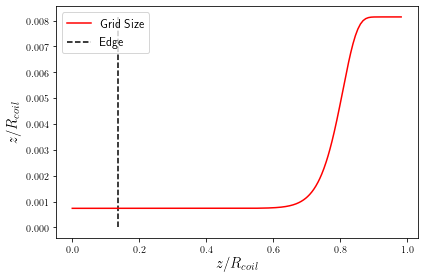

In [6]:
def spacing_r(r, dr, R_wall, R_coil, res_r):
    
    sigma_dr = (R_wall-R_coil)/2.5#Width of the gaussian
    #APEX
    dr0 = 2.68*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    #Matt
    #dr0 = 2.85*R_wall/res_r #Diastance of the first grid points. I chose this value so that sum(dr) = R_wall
    dr_min = dr0*0.2 #Minimal Distance of two grid points
    R_exp = 1.25*R_coil #Maxima of the super-gaussian = minima in grid spacing
    exp_r = 10
    
    if len(dr) == 0:
        dr = 2*[dr0+dr_min]
        r = [R_wall, R_wall-dr0]
    dr_i = 2*dr[-1] - dr[-2] #of the next grid point to calculate the corresponding spacing
    dr.append(dr0*(1-np.exp(-(r[-1]-dr[-1]-R_exp)**exp_r/(sigma_dr**exp_r)))+dr_min) #and I need the spacing
    r.append(r[-1]-dr[-1])
    
    return r, dr

def spacing_z(z, dz, R_coil, H, res_z):
    
    sigma_dz = 0.4*H
    dz0 = 3.7*H/res_z
    dz_min = 0.1*dz0
    exp_z = 20

    if len(dz) == 0:
        dz = 2*[dz0+dz_min]
        z = [H/2, H/2-dz0]
    dz_i = 2*dz[-1] - dz[-2]
    dz.append(dz0*(1-np.exp(-(z[-1]-dz[-1])**exp_z/(2*sigma_dz**exp_z)))+dz_min)
    z.append(z[-1]-dz[-1])
        
    return z, dz

r, z, dr, dz, r0, z0 = dt.grid(R_coil, R_wall, H, res_r, res_z, spacing_r, spacing_z, 0)
show = dt.check_grid(r, z, r0, z0, R_coil, dR_coil, dr, dz, res_r, res_z)

In [7]:
z_ue = abs(z-dR_coil/2) #height of the upper edge of the coil 
i_ue = np.argmin(z_ue) #index of the upper edge of the coil
i_le = 0
r_ie = abs(r-(R_coil-dR_coil/2)) #radius of the inner edge of the coil 
i_ie = np.argmin(r_ie) #index of the inner edge of the coil 
r_oe = abs(r-(R_coil+dR_coil/2)) #radius of the outer edge of the coil 
i_oe = np.argmin(r_oe) #index of the outer edge of the coil
i_coil = np.argmin(abs(r-(R_coil))) #index of the outer edge of the coil
i_bottom = np.argmin(abs(r-(r[i_oe]+r[-1])/2)) #Index of the radius in between coil and wall 
                                               #(approximatly the bottom of the potential well)
i_mid = np.argmin(abs(z))

In [8]:
mask = np.zeros((res_r, res_z))

data, col, row = dt.laplace_electrodes(r, dr, dz, mask)
A = csc_matrix((data, (col, row)), shape=(res_r*res_z, res_r*res_z))
del data, col, row 
lu = sla.splu(A) #Anna schreibt mit am heiligen Kot 

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'rz' of function 'AGM_Dipole'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "Dipole_Tools_1D.py", line 357:
@njit(parallel = True)
def AGM_Dipole(itr, r, z, rz, dz, C,res_r, res_z, R):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


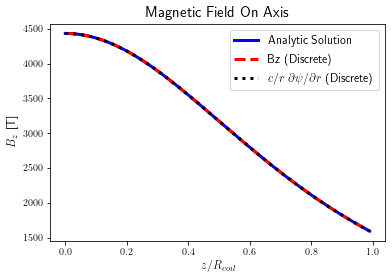

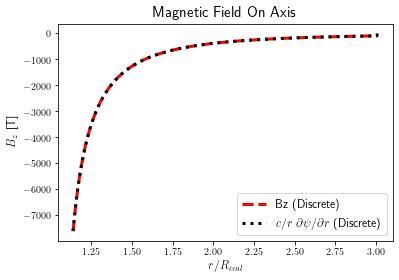

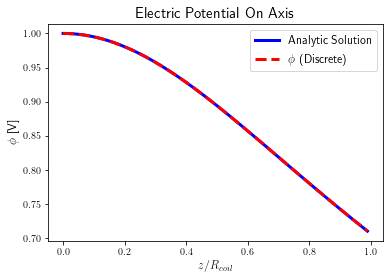

In [9]:
C = (2*I/c) #Scaling factor for Magnetic field/flux
Field_in = 0
if Field_in == 0:
    rz = np.meshgrid(z, r)
    psi, Bz, Br, phi_coil =  dt.AGM_Dipole(20, r, z, rz, dz, C, res_r, res_z, R_coil)
    Bz[0, :] = Bz[1, :]
    #np.savetxt('psi.txt', psi)
    #np.savetxt('Bz.txt', Bz)
    #np.savetxt('Br.txt', Br)
    #np.savetxt('phi_coil.txt', phi_coil)
    del  rz
elif Field_in == 1:
    psi = np.loadtxt('psi.txt')
    Bz = np.loadtxt('Bz.txt')
    Br = np.loadtxt('Br.txt')
    phi_coil = np.loadtxt('phi_coil.txt')

#psi_in, Bz_in, Br_in, dpsi_dr_in = AGM_test(4, r, z, rz, dz, C, R_coil, res_r, res_z)
dpsi_dr_dis = np.zeros((res_r, res_z))
for i in range(1, res_r-1):
    dr_i = (dr[i-1]+dr[i])*r[i]
    for j in range(res_z):
        dpsi_dr_dis[i, j] = (psi[i+1, j] - psi[i-1, j])/(dr_i)

Bz_ana = C*np.pi*R_coil**2/(z**2+R_coil**2)**(3/2)

plt.plot(z/R_coil, Bz_ana, 'b', label='Analytic Solution', linewidth=3)
plt.plot(z/R_coil, Bz[0, :], 'r', label='Bz (Discrete)', linewidth=3, linestyle='dashed')
plt.plot(z/R_coil, dpsi_dr_dis[2, :], 'k', label='$c/r \ \partial \psi/\partial r$ (Discrete)', linestyle='dotted', linewidth=3)
plt.legend(fontsize = 12)
plt.xlabel('$z/R_{coil}$', fontsize=12)
plt.ylabel('$B_z$ [T]', fontsize=12)
plt.title('Magnetic Field On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

plt.plot(r[i_oe:]/R_coil, Bz[i_oe:, 0], 'r', label='Bz (Discrete)', linewidth=3, linestyle='dashed')
plt.plot(r[i_oe:]/R_coil, dpsi_dr_dis[i_oe:, 0], 'k', label='$c/r \ \partial \psi/\partial r$ (Discrete)', linestyle='dotted', linewidth=3)
plt.legend(fontsize = 12)
plt.xlabel('$r/R_{coil}$', fontsize=12)
plt.ylabel('$B_z$ [T]', fontsize=12)
plt.title('Magnetic Field On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

phi_ana = 1/np.sqrt(z**2+R_coil**2)

plt.plot(z/R_coil, phi_ana/np.max(phi_ana), 'b', label='Analytic Solution', linewidth=3)
plt.plot(z/R_coil, phi_coil[0, :]/np.max(phi_coil[0, :]), 'r', label='$\phi$ (Discrete)', linewidth=3, linestyle='dashed')
plt.legend(fontsize = 12)
plt.xlabel('$z/R_{coil}$', fontsize=12)
plt.ylabel('$\phi$ [V]', fontsize=12)
plt.title('Electric Potential On Axis', fontsize=15)
#plt.savefig('Bz_check.png', dpi = 400)
plt.show()

In [10]:
print(c*np.sqrt(2*me*T0)/(e*Bz_ana[0]))
print((e*Bz_ana[0])/(c*me))
print(np.sqrt(1e13*(1.602e-19)**2/(2*9.1e-31*8.8e-12)))


0.0007603383569201285
78001688275.4744
126585943.13351306


In [11]:
rz = np.meshgrid(z, r)
f_gte = f_interp.ev(rz[1], rz[0])

f_norm = abs(f_gte[:, 0])
check = 0
for i in range(i_oe+1, res_r):
    if check == 0 and f_norm[i] > 1e-4:
        i_max = i
        check = 1
    if check == 1 and f_norm[i] <= 1e-4:     
        i_min = i
        break

mask_lte = np.zeros((res_r, res_z))
mask_lte[psi>psi[i_min, 0]] = 1
mask_lte[psi>psi[i_max, 0]] = 0
mask_lte[i_ie:i_oe, i_le:i_ue] = 0

del rz
print(r[i_max]/R_coil, r[i_min]/R_coil)

1.456357221843082 2.6039617500812877


In [12]:
filename_load = 'LTE2GTE'
delta = 0.01   #Step width for the change of the potentiall from one iteration to the next
ddelta = 0.1*delta #Change of step width if error decreases
delta_min = ddelta #Minimum Step width
#b = [0.8, 0.2, 0.05, 0.0]
b = []
T = 0.5*T0

for i in range(len(b)):
    
    #cent = -np.transpose((me*omega**2/(2*q))*np.array(res_z*[r**2])) #Effective centrifugal potential
    #cent[0, :] = 0
    scale = omega*I*R_coil/c**2
    boundary_top = phi_coil[:, -1] 
    boundary_out = phi_coil[-1, :]
    f_wall = np.zeros((res_r, res_z))
    f_wall[-1, :] = -boundary_out*(1/r[-1]+2/dr[-1])/(dr[-2] + dr[-1])
    f_wall[:, -1] += -2*boundary_top/((dz[-1] + dz[-2])*dz[-1])
    phi_wall = lu.solve(f_wall.flatten())
    phi_wall = dt.array22d(phi_wall, res_r, res_z)
    phi_trap = b[i]*scale*(phi_coil - phi_wall)
    phi_rot = -phi_trap + (omega/c)*psi# + cent

    if b[i] == 0.8: 
        itr = 400
        f_2d = f_gte.copy()
        f_2d[f_2d<0] = 0
        F0 = dt.N_tot(f_2d, r, z, dr, dz, res_r, res_z)
        N0 = F0/(4*np.pi*e)
        print('N = %1.2e' %(N0))
        f = f_2d.flatten()
        phi = lu.solve(f)
        phi_2d = dt.array22d(phi, res_r, res_z)
        phi_tot = phi_2d + phi_rot
        phi_el = phi_2d + phi_trap
        phi_psi_inter = interp1d(psi[i_max-1:i_min+1, 0], phi_tot[i_max-1:i_min+1, 0], kind = 'cubic', bounds_error=False, fill_value=0)
        phi_psi = phi_psi_inter(psi)
        phi_tot = phi_tot - phi_psi  

        diff = 1e20 #Initialize difference between iteration, I use that as a measure of the convergence
        sum_error = 1e30
    else:
        itr = 1000
        phi_2d = np.loadtxt(filename_load+'_'+str(round(b[i-1], 2))+'potential.txt')
        f_2d = np.loadtxt(filename_load+'_'+str(round(b[i-1], 2))+'distribution.txt')
        F0 = dt.N_tot(f_2d, r, z, dr, dz, res_r, res_z)
        N0 = F0/(4*np.pi*e)
        f = f_2d.flatten()
        phi = phi_2d.flatten()
        phi_tot = phi_2d + phi_rot
        phi_psi_inter = interp1d(psi[i_max-1:i_min+1, 0], phi_tot[i_max-1:i_min+1, 0], kind = 'cubic', bounds_error=False, fill_value=0)
        phi_psi = phi_psi_inter(psi)
        phi_tot = phi_tot - phi_psi  
        phi_el = phi_2d + phi_trap
        sum_error = 1e30#Error[-1]
        diff = 1e20#Diff[-1]

    Error = np.zeros((itr))
    Diff = np.zeros((itr))  

    for m in range(itr):

        f0 = f  #Save last distribution and calculate new Boltzmann distribuion from old potential
        f_psi_inter = interp1d(psi[i_max:i_min, 0], f_norm[i_max:i_min]/np.exp(-q*phi_tot[i_max:i_min, 0]/T), kind = 'cubic', bounds_error=False, fill_value=0)    
        F_psi = f_psi_inter(psi)
        f_2d = np.nan_to_num(mask_lte*F_psi*np.exp(-q*phi_tot/T))
        f_2d[f_2d<0] = 0
        f_2d = dt.F_norm(f_2d, F0, r, z, dr, dz, mask_lte, res_r, res_z)
        f_2d = np.nan_to_num(f_2d)
        f = f_2d.flatten()

        d2phi = A.dot(-phi)
        sum_error0 = sum_error
        sum_error = abs(dt.N_error(d2phi, f, mask_lte, r, z, dz, e, res_r, res_z))
        Error[m] = sum_error #Add error to list                         
        diff0 = diff #Save old difference
        diff = np.sum(abs(f-f0)) #Calculate new difference
        Diff[m] = np.sum(diff) #Add difference to list 
        if sum_error/100 > sum_error0 and cooling == 1:
            T = T + 0.01*T0*2/itr
            print('Cooling off at itertation ', m)
            print(sum_error/sum_error0)
        if sum_error <= sum_error0:
            phi1 = lu.solve(delta*f+(1-delta)*f0)
            phi = phi1*delta + (1-delta)*phi #Solve Poissons Equation
            delta += ddelta
        elif sum_error > sum_error0:
            phi1 = lu.solve(f0)
            phi = phi1*delta + (1-delta)*phi
            delta = np.max((delta/2, delta_min))
        phi = np.nan_to_num(phi)
        phi_2d = dt.array22d(phi, res_r, res_z)
        phi_tot = phi_2d + phi_rot
        
        phi_psi_inter = interp1d(psi[i_max-1:i_min+1, 0], phi_tot[i_max-1:i_min+1, 0], kind = 'cubic', bounds_error=False, fill_value=0)
        phi_psi = phi_psi_inter(psi)
        phi_tot = phi_tot - phi_psi  

    phi_el = phi_2d + phi_trap
    n_2d = f_2d/(4*np.pi*e)
    n_2d[i_ie:i_oe, i_le:i_ue] = 0

    i_max_n = np.argmax(n_2d[:i_ie, 0])
    maxi = 1.05
    mini = 0
    psi_contour = np.zeros((res_r, res_z))
    psi_contour[psi < psi[i_max_n, 0]] = 0.01
    contours_C = np.arange(mini, maxi, (maxi-mini)/200)

    fig, ax = plt.subplots(figsize=(6, 2))
    im = ax.contourf(r/R_coil, z/R_coil, np.transpose(n_2d/np.max(n_2d)), contours_C, cmap='nipy_spectral')
    ax.set_xlabel(r"$\rho$", fontsize = 15)
    ax.set_ylabel(r"$\xi$", fontsize = 15)
    ax.tick_params(labelsize=15) 
    cb_ax = fig.add_axes([0.905, 0.125, 0.02, 0.755])
    cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5))
    tick_labels = [str(round(i, 2)) for i in np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5)]
    cbar.ax.set_yticklabels(tick_labels, fontsize=15)
    cbar.set_label(label = r'$n/n_{max}$',fontsize=15)
    plt.show()

    fig, ax1 = plt.subplots()
    color = 'b'
    ax1.set_ylabel('|$f_i - f_{i+1}$|', color=color, fontsize = 15)
    ax1.plot(Diff[2:], label='Convergence', color = 'b')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.yscale('log')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-ax
    color = 'r'
    ax2.set_ylabel('$\int dV |\epsilon_0/q \Delta\phi_i+n_i|$', color=color, fontsize = 15)
    ax2.plot(Error[2:], label='Error', color = 'r')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.yscale('log')
    plt.grid()
    fig.legend(loc = (0.57, 0.6), fontsize = 12)
    plt.title('Error and Convergence', fontsize = 15)
    plt.savefig('Error_Convergence.jpg', dpi = 400)
    plt.show()    

    filename_save = 'LTE2GTE'
    #save = 'n'
    save = input('save data? y/n ')
    if save == 'y':    
        np.savetxt(filename_save+'_'+str(round(b[i], 2))+'potential.txt', phi_2d)
        np.savetxt(filename_save+'_'+str(round(b[i], 2))+'distribution.txt', f_2d)

In [13]:
b = [0.8, 0.2, 0.05, 0.0]
filename_save = 'LTE2GTE'
n1 = np.loadtxt(filename_save+'_'+str(round(b[0], 2))+'distribution.txt')/(4*np.pi*e)
#phi1 = np.loadtxt(filename_save+'_b'+str(round(b[0], 2))+'potential.txt')
n1[i_ie:i_oe, i_le:i_ue] = 0

n2 = np.loadtxt(filename_save+'_'+str(round(b[1], 2))+'distribution.txt')/(4*np.pi*e)
#phi2 = np.loadtxt(filename_save+'_b'+str(round(b[1], 2))+'potential.txt')
n2[i_ie:i_oe, i_le:i_ue] = 0

n3 = np.loadtxt(filename_save+'_'+str(round(b[2], 2))+'distribution.txt')/(4*np.pi*e)
#phi3 = np.loadtxt(filename_save+'_b'+str(round(b[2], 2))+'potential.txt')
n3[i_ie:i_oe, i_le:i_ue] = 0

n4 = np.loadtxt(filename_save+'_'+str(round(b[3], 2))+'distribution.txt')/(4*np.pi*e)
phi4 = np.loadtxt(filename_save+'_'+str(round(b[3], 2))+'potential.txt')
n4[i_ie:i_oe, i_le:i_ue] = 0

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: The following kwargs were not used by contour: 'linestyle'


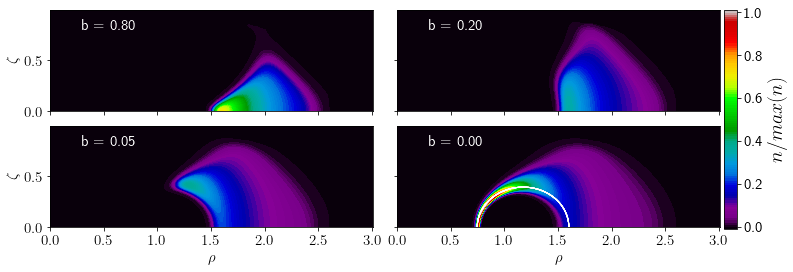

In [14]:
scale_n = 1/np.max(n4)#e**2*R_coil**2/(T0*T[0])

psi_contour = np.zeros((res_r, res_z))
#psi_contour[psi<psi[np.argmax(n4)//res_z, np.argmax(n4)%res_z]] = 1
psi_contour[psi<psi[np.argmax(n4[i_oe:, 0])+i_oe, 0]] = 1

maxi = 1.02
mini = -0.01#np.min(n4*10**-mag_n)
contours_n = np.arange(mini, maxi, (maxi-mini)/100)
contour_psi = np.arange(0, 1.1, 0.1)

fig, axs = plt.subplots(2, 2, sharex='col', sharey='row', gridspec_kw={'wspace': 0.075, 'hspace': 0.15}, figsize=(12, 4))
((ax1, ax2), (ax3, ax4)) = axs

im1 = ax1.contourf(r/R_coil, z/R_coil, np.transpose(scale_n*n1), contours_n, cmap='nipy_spectral')
ax1.set_ylabel(r"$\zeta$", fontsize = 15)
ax1.tick_params(axis ='both', labelsize=15)
ax1.text(0.3, 0.8, 'b = %1.2f' %(b[0]), color = 'w', fontsize=15)

im2 = ax2.contourf(r/R_coil, z/R_coil, np.transpose(scale_n*n2), contours_n, cmap='nipy_spectral')
ax2.tick_params(axis ='both', labelsize=15)
ax2.text(0.3, 0.8, 'b = %1.2f' %(b[1]), color = 'w', fontsize=15)

im3 = ax3.contourf(r/R_coil, z/R_coil, np.transpose(scale_n*n3), contours_n, cmap='nipy_spectral')
ax3.set_xlabel(r"$\rho$", fontsize = 15)
ax3.set_ylabel(r"$\zeta$", fontsize = 15)
ax3.tick_params(axis ='both', labelsize=15)
ax3.text(0.3, 0.8, 'b = %1.2f' %(b[2]), color = 'w', fontsize=15)

im4 = ax4.contourf(r/R_coil, z/R_coil, np.transpose(scale_n*n4), contours_n, cmap='nipy_spectral')
ax4.contour(r/R_coil, z/R_coil, np.transpose(psi_contour), contour_psi, colors='w', linewidths=1, linestyle="dashed")
ax4.set_xlabel(r"$\rho$", fontsize = 15)
ax4.tick_params(axis ='both', labelsize=15)
ax4.text(0.3, 0.8, 'b = %1.2f' %(b[3]), color = 'w', fontsize=15)

cb_ax = fig.add_axes([0.905, 0.12, 0.015, 0.76])
cbar = fig.colorbar(im4, cax=cb_ax, ticks = np.arange(0, 1.2, 0.2))
tick_labels = [str(abs(round(i, 1))) for i in np.arange(0, 1.2, 0.2)]
cbar.ax.set_yticklabels(tick_labels, fontsize=15) 
cbar.set_label(label = '$n/max(n)$',fontsize=20)
plt.savefig('Steinbrunner_Fig7.png', format = 'png', bbox_inches="tight", dpi=300)
plt.savefig('Steinbrunner_Fig7.tif', format = 'tif', bbox_inches="tight", dpi=300)

In [ ]:
itr = 500
guess = 1
delta = 0.001   #Step width for the change of the potentiall from one iteration to the next
ddelta = 0.1*delta #Change of step width if error decreases
delta_min = ddelta #Minimum Step width
#T = 0.5*T0
T_psi = T0*(0.5/(psi[i0, 0]-psi[i_oe, 0]))*(psi[:, 0]-psi[i_oe, 0])
t_psi_inter = interp1d(psi[i_max:i_min, 0], T_psi[i_max:i_min], kind = 'cubic', bounds_error=False, fill_value=10*T0)
T_psi_2d = t_psi_inter(psi)

for b_i in [0.0]:

    boundary_top = phi_coil[:, -1] #+ d_i/b_i
    boundary_out = phi_coil[-1, :]
    f_wall = np.zeros((res_r, res_z))
    f_wall[-1, :] = -boundary_out*(1/r[-1]+2/dr[-1])/(dr[-2] + dr[-1])
    f_wall[:, -1] += -2*boundary_top/((dz[-1] + dz[-2])*dz[-1])
    phi_wall = lu.solve(f_wall.flatten())
    phi_wall = dt.array22d(phi_wall, res_r, res_z)
    phi_coil_wall = -(omega/c)*2*np.pi*C*b_i*(phi_coil - phi_wall)
    phi_vac = (phi_coil_wall + (omega/c)*psi)

    if guess == 0:       
        f_2d = f_gte.copy()
        F0 = dt.N_tot(f_2d, r, z, dr, dz, res_r, res_z)
        N0 = F0/(4*np.pi*e)
        print('N = %1.2e' %(N0))
        f = f_2d.flatten()
        phi = lu.solve(f)
        phi_2d = dt.array22d(phi, res_r, res_z)
        phi_tot = phi_2d + phi_vac
        phi_el = phi_2d + phi_coil_wall
        phi_psi_inter = interp1d(psi[i_max-1:i_min+1, 0], phi_tot[i_max-1:i_min+1, 0], kind = 'cubic', bounds_error=False, fill_value=0)
        phi_psi = phi_psi_inter(psi)
        phi_tot = phi_tot - phi_psi  

        diff = 1e20 #Initialize difference between iteration, I use that as a measure of the convergence
        sum_error = 1e30
    elif guess == 1:
        phi_2d = np.loadtxt(filename_load+'_b'+str(round(b_i, 2))+'potential.txt')
        f_2d = np.loadtxt(filename_load+'_b'+str(round(b_i, 2))+'distribution.txt')
        #f_2d = np.loadtxt(filename_load+'_T'+str(round(T/T0, 2))+'distribution.txt')
        #phi_2d = np.loadtxt(filename_load+'_T'+str(round(T/T0, 2))+'potential.txt')
        f = f_2d.flatten()
        phi = phi_2d.flatten()
        phi_tot = phi_2d + phi_vac
        phi_psi_inter = interp1d(psi[i_max-1:i_min+1, 0], phi_tot[i_max-1:i_min+1, 0], kind = 'cubic', bounds_error=False, fill_value=0)
        phi_psi = phi_psi_inter(psi)
        phi_tot = phi_tot - phi_psi  
        phi_el = phi_2d + phi_vac
        #F0 = dt.N_tot(f_2d, r, z, dr, dz, res_r, res_z)
        #N0 = F0/(4*np.pi*e)
        N0 = 5.3e10
        F0 = N0*(4*np.pi*e)
        print('N = %1.2e' %(N0))
        #Diff = list(np.loadtxt(filename+'Divergence.txt'))
        #Error = list(np.loadtxt(filename+'Error.txt'))
        sum_error = 1e30#Error[-1]
        diff = 1e20#Diff[-1]

    Error = np.zeros((itr))
    Diff = np.zeros((itr))  

    for m in range(itr):

        if cooling == 1:
            T = 0.02*T0 - 0.01*T0*m/itr
        f0 = f  #Save last distribution and calculate new Boltzmann distribuion from old potential
        #f_psi_inter = interp1d(psi[i_max:i_min, 0], f_norm[i_max:i_min]/np.exp(-q*phi_tot[i_max:i_min, 0]/T), kind = 'cubic', bounds_error=False, fill_value=0)
        f_psi_inter = interp1d(psi[i_max:i_min, 0], f_norm[i_max:i_min]/np.exp(-q*phi_tot[i_max:i_min, 0]/T_psi_2d[i_max:i_min, 0]), kind = 'cubic', bounds_error=False, fill_value=0)
        F_psi = f_psi_inter(psi)
        #f_2d = np.nan_to_num(mask_lte*F_psi*np.exp(-q*phi_tot/T))
        f_2d = np.nan_to_num(mask_lte*F_psi*np.exp(-q*phi_tot/T_psi_2d))
        f_2d[f_2d<0] = 0
        f_2d = dt.F_norm(f_2d, F0, r, z, dr, dz, mask_lte, res_r, res_z)
        f_2d = np.nan_to_num(f_2d)
        f = f_2d.flatten()

        d2phi = A.dot(-phi)
        sum_error0 = sum_error
        sum_error = abs(dt.N_error(d2phi, f, mask_lte, r, z, dz, e, res_r, res_z))
        #print(sum_error)
        Error[m] = sum_error #Add error to list                         
        diff0 = diff #Save old difference
        diff = np.sum(abs(f-f0)) #Calculate new difference
        #print(diff)
        Diff[m] = np.sum(diff) #Add difference to list 
        if sum_error/100 > sum_error0 and cooling == 1:
            T = T + 0.01*T0*2/itr
            print('Cooling off at itertation ', m)
            print(sum_error/sum_error0)
        if sum_error <= sum_error0:
            phi1 = lu.solve(delta*f+(1-delta)*f0)
            phi = phi1*delta + (1-delta)*phi #Solve Poissons Equation
            delta += ddelta
        elif sum_error > sum_error0:
            phi1 = lu.solve(f0)
            phi = phi1*delta + (1-delta)*phi
            delta = np.max((delta/2, delta_min))
        phi = np.nan_to_num(phi)
        phi_2d = dt.array22d(phi, res_r, res_z)
        phi_tot = phi_2d + phi_vac
        
        phi_psi_inter = interp1d(psi[i_max-1:i_min+1, 0], phi_tot[i_max-1:i_min+1, 0], kind = 'cubic', bounds_error=False, fill_value=0)
        phi_psi = phi_psi_inter(psi)
        phi_tot = phi_tot - phi_psi  
        
        #if m%200 == 0:
        #    print('Iteration ', m)
    phi_el = phi_2d + phi_coil_wall
    n_2d = f_2d/(4*np.pi*e)
    n_2d[i_ie:i_oe, i_le:i_ue] = 0

    i_max_n = np.argmax(n_2d[:i_ie, 0])
    maxi = 1.05
    mini = 0
    psi_contour = np.zeros((res_r, res_z))
    psi_contour[psi < psi[i_max_n, 0]] = 0.01
    contours_C = np.arange(mini, maxi, (maxi-mini)/200)

    fig, ax = plt.subplots(figsize=(6, 2))
    im = ax.contourf(r/R_coil, z/R_coil, np.transpose(n_2d/np.max(n_2d)), contours_C, cmap='nipy_spectral')
    im_psi = ax.contour(r/R_coil, z/R_coil, np.transpose(psi_contour), contours_C, colors='w', linestyles='dashed')
    ax.set_xlabel(r"$\rho$", fontsize = 15)
    ax.set_ylabel(r"$\xi$", fontsize = 15)
    ax.tick_params(labelsize=15) 
    cb_ax = fig.add_axes([0.905, 0.125, 0.02, 0.755])
    cbar = fig.colorbar(im, cax=cb_ax, ticks = np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5))
    tick_labels = [str(round(i, 2)) for i in np.arange(mini, maxi+(maxi-mini)/5, (maxi-mini)/5)]
    cbar.ax.set_yticklabels(tick_labels, fontsize=15)
    cbar.set_label(label = r'$n/n_{max}$',fontsize=15)
    #ax.set_title('$\phi + Tln(n/n_0)/q$', fontsize=20)
    #plt.savefig('Force_Balance_LTE.png', dpi = 400)
    plt.show()

    fig, ax1 = plt.subplots()
    color = 'b'
    ax1.set_ylabel('|$f_i - f_{i+1}$|', color=color, fontsize = 15)
    ax1.plot(Diff[2:], label='Convergence', color = 'b')
    ax1.tick_params(axis='y', labelcolor=color)
    plt.yscale('log')
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-ax
    color = 'r'
    ax2.set_ylabel('$\int dV |\epsilon_0/q \Delta\phi_i+n_i|$', color=color, fontsize = 15)
    ax2.plot(Error[2:], label='Error', color = 'r')
    ax2.tick_params(axis='y', labelcolor=color)
    plt.yscale('log')
    plt.grid()
    fig.legend(loc = (0.57, 0.6), fontsize = 12)
    plt.title('Error and Convergence', fontsize = 15)
    #plt.savefig('Error_Convergence.jpg', dpi = 400)
    plt.show()    

    filename_save = 'dT_psi10'
    save = 'n'
    #save = input('save data? y/n ')
    if save == 'y':    
        #np.savetxt(filename_save+'_T'+str(round(T/T0, 2))+'potential.txt', phi_2d)
        #np.savetxt(filename_save+'_T'+str(round(T/T0, 2))+'distribution.txt', f_2d)
        np.savetxt(filename_save+'_b'+str(round(b_i, 2))+'potential.txt', phi_2d)
        np.savetxt(filename_save+'_b'+str(round(b_i, 2))+'distribution.txt', f_2d)

In [ ]:
check = 0
for i in range(i_oe+1, res_r):
    if check == 0 and n4[i, 0] > 1:
        i_max = i
        check = 1
    if check == 1 and n4[i, 0] <= 1:     
        i_min = i
        break

dpsi = np.max(abs(psi))/10000
r_psi = [r[i_min]]
psi_r = []
n = 0
dr0 = 0.001
while r_psi[n]>=r[i_max]: 
    psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, r_psi[n], 0, R_coil, C)
    #if abs(dpsi/dpsi_dr) > abs(3*dr0):
    #    r_psi.append(r_psi[n]-abs(3*dr0))
    #else:
    r_psi.append(r_psi[n]-abs(dpsi/dpsi_dr))
    dr0 = dpsi/dpsi_dr
    psi_r.append(psi_n)
    n+=1
    if n>5000:
        print('More then 5000 grid points. Did not finish!')
        break 
print(len(r_psi))

psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, r[i_max], 0, R_coil, C)
psi_r.append(psi_n)
r_psi = np.array(r_psi[::-1])
psi_r = np.array(psi_r[::-1])

In [ ]:
def psi_grid(r_psi, n_psi, R_coil, C):
    
    ds = 1e-4
    ds1 = 1e1    
    
    psi_grid_r = [r_psi[n_psi]]
    psi_grid_z = [0]    
    psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, r_psi[n_psi], 0, R_coil, C)
    psi_grid_r1 = [r_psi[n_psi] - ds1/dpsi_dr]
    psi_grid_z1 = [0]
    B_psi = []
    B_z = []

    n = 0
    z_check = 0
    
    while z_check == 0: 

        psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, psi_grid_r[n], psi_grid_z[n], R_coil, C)

        norm = np.sqrt(np.nan_to_num(dpsi_dr**2 + dpsi_dz**2))
        ds_r = np.nan_to_num(ds*dpsi_dz/norm)
        ds_z = -np.nan_to_num(ds*dpsi_dr/norm)
        psi_grid_r.append(psi_grid_r[n]+ds_r) 
        psi_grid_z.append(psi_grid_z[n]+ds_z)
        B_psi.append(np.sqrt(dpsi_dr**2 + dpsi_dz**2)/psi_grid_r[n])
        B_z.append(dpsi_dr/psi_grid_r[n])
        #if abs(dpsi_dr) > 2*abs(dpsi_dz) or abs(dpsi_dz) > 2*abs(dpsi_dr):
        psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, psi_grid_r1[n], psi_grid_z1[n], R_coil, C)
        norm = np.sqrt(np.nan_to_num(dpsi_dr**2 + dpsi_dz**2))
        ds_r = np.nan_to_num(ds*dpsi_dz/norm)
        ds_z = -np.nan_to_num(ds*dpsi_dr/norm)
        psi_grid_r1.append(psi_grid_r1[n]+ds_r) 
        psi_grid_z1.append(psi_grid_z1[n]+ds_z) 
        #else:
        #    psi_grid_r1.append(psi_grid_r[n]-ds1/dpsi_dr) 
        #    psi_grid_z1.append(psi_grid_z[n]-ds1/dpsi_dz)
        if psi_grid_z[n+1] <= 0:
            z_check = 1
        n+=1
    psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, psi_grid_r[n], psi_grid_z[n], R_coil, C)
    B_psi.append(np.sqrt(dpsi_dr**2 + dpsi_dz**2)/psi_grid_r[n])
    B_z.append(dpsi_dr/psi_grid_r[n])
    
    B_psi = np.array(B_psi)
    B_z = np.array(B_z)
    psi_grid_r = np.array(psi_grid_r)
    psi_grid_z = np.array(psi_grid_z)
    psi_grid_r1 = np.array(psi_grid_r1)
    psi_grid_z1 = np.array(psi_grid_z1)
    print(len(psi_grid_r), len(psi_grid_r1))
    
    return psi_grid_r, psi_grid_z, psi_grid_r1, psi_grid_z1, B_psi, B_z

In [ ]:
#n_psi = np.argmin(abs(r_psi-r[i0]))
n_psi = np.argmin(abs(psi_r-psi[np.argmax(n4)//res_z, np.argmax(n4)%res_z]))#-30
#n_psi = np.argmin(abs(psi_r-psi[np.argmax(n4[i_oe:, 0])+i_oe, 0]))
psi_grid_r, psi_grid_z, psi_grid_r1, psi_grid_z1, B_psi, B_z = psi_grid(r_psi, n_psi, R_coil, C)
plt.plot(psi_grid_r/R_coil, psi_grid_z/R_coil, 'b')
plt.plot(psi_grid_r1/R_coil, psi_grid_z1/R_coil, 'r')
plt.xlabel('$r/R_{coil}$', fontsize=15)
plt.ylabel('$z/R_{coil}$', fontsize=15)
plt.title('Grid Points on Flux Contours', fontsize=20)
plt.show()

In [ ]:
norm = c**2/(omega*I*R_coil)
t_psi = T0*0.5

n_interp = RectBivariateSpline(r, z, n4, kx=3, ky=3)
n_ab = n_interp.ev(psi_grid_r, psi_grid_z)

phi_interp = RectBivariateSpline(r, z, phi4, kx=3, ky=3)
phi_ab = phi_interp.ev(psi_grid_r, psi_grid_z)
phi_ab = np.nan_to_num(phi_ab)

dchi = np.array([B_psi[n]*np.sqrt((psi_grid_r[n+1]-psi_grid_r[n])**2+(psi_grid_z[n+1]-psi_grid_z[n])**2) for n in range(len(psi_grid_r)-1)])
chi = np.zeros(len(dchi))
for i in range(1, len(chi)):
    chi[i] = chi[i-1]+dchi[i]
chi = chi/(R_coil*Bz[0, 0])

offset = np.mean(norm*(phi_ab[:-1]+t_psi*np.log(n_ab[:-1]/n_ab[-1])/q))

plt.plot(chi, norm*(phi_ab[:-1])-offset, label = '$q\phi+const.$', color='b')
plt.plot(chi, norm*t_psi*np.log(n_ab[:-1]/n_ab[-1])/q, label = '$T ln(n/n_{max})$', color='r')
plt.plot(chi, norm*(phi_ab[:-1]+t_psi*np.log(n_ab[:-1]/n_ab[-1])/q)-offset, label = '$q\phi+T ln(n/n_{max})+const.$', color='m')
plt.ylabel('$q\phi$ [a.u.]', fontsize=15)
plt.xlabel(r'$(B_0R)^{-1} \chi$', fontsize=15)
#plt.title('Electric Potential along Flux Contour', fontsize=20)
plt.grid()
#plt.title('Potential along Flux Contour', fontsize=15)
plt.legend(fontsize=12)
plt.savefig('Steinbrunner_Fig8.png', format = 'png', bbox_inches="tight", dpi=300)
plt.savefig('Steinbrunner_Fig8.tif', format = 'tif', bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
print(np.mean(norm*(phi_ab[:-1]+t_psi*np.log(n_ab[:-1]/n_ab[-1])/q)))

In [ ]:
psi_check = np.empty(len(psi_grid_r))
for i in range(len(psi_grid_r)):
    psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, psi_grid_r[i], psi_grid_z[i], R_coil, C)
    psi_check[i] = psi_n

psi_check = np.array(psi_check)
#plt.plot(psi_grid_r[300:]/R_coil, psi_check[300:], 'b')
#plt.plot(psi_grid_r1[300:]/R_coil, psi_check1[300:], 'r')
plt.plot(chi, psi_check[:-1], 'r')
plt.ylabel('$\psi$', fontsize=15)
plt.xlabel(r'$(B_0R)^{-1} \chi$', fontsize=15)
plt.title('Flux along Flux Contour', fontsize=20)
plt.grid()
plt.show()

In [ ]:
print(T0, norm, q, T0/q, I, omega, R_coil)
print(n_ab[-1], n_ab[-2])

In [ ]:
i_max_n = np.argmin(abs(psi[:, 0]-psi_r[n_psi]))

print(n4[i_max_n, 0], r[i_max_n]/R_coil, i_max_n)
print(np.sqrt(T0*0.5/(4*np.pi*e**2*n4[i_max_n, 0]))/R_coil)

In [ ]:
i_max_n = np.argmin(abs(psi[:, 0]-psi[np.argmax(n4)//res_z, np.argmax(n4)%res_z]))
i0 = np.argmin(abs(psi[i_oe:, 0]-psi[i_max_n, 0]))+i_oe
T_psi = (0.5/(psi[i0, 0]-psi[i_oe, 0]))*(psi[:, 0]-psi[i_oe, 0])
T_psi_inter = interp1d(psi[i_max-1:i_min+1, 0], T_psi[i_max-1:i_min+1], kind = 'cubic', bounds_error=False, fill_value=0)
T_psi_2d = T0*T_psi_inter(psi)

In [ ]:
psi_check = np.empty(len(psi_grid_r))
psi_check1 = np.empty(len(psi_grid_r))
for i in range(len(psi_grid_r)):
    psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, psi_grid_r[i], psi_grid_z[i], R_coil, C)
    psi_check[i] = psi_n
    psi_n, dpsi_dr, dpsi_dz = dt.AGM_0D(20, psi_grid_r1[i], psi_grid_z1[i], R_coil, C)
    psi_check1[i] = psi_n
psi_check1 = np.array(psi_check1)
psi_check = np.array(psi_check)
dpsi = np.mean(psi_check1-psi_check)
phi_ab1 = phi_interp.ev(psi_grid_r1, psi_grid_z1)
phi_ab1 = np.nan_to_num(phi_ab1)

n_ab1 = n_interp.ev(psi_grid_r1, psi_grid_z1)
n_ab1 = np.nan_to_num(n_ab1)

omega_EXB = -c*(phi_ab1-phi_ab)/(psi_check1-psi_check)
omega_dia = c*t_psi*(n_ab1-n_ab)/((psi_check1-psi_check)*n_ab*e)
omega_cent = c*me*omega**2*B_z/(q*B_psi**2)
omega_tot = omega_dia+omega_EXB#+omega_cent
omega_mean = np.mean(omega_tot)

phi_dT = np.loadtxt('LTE2GTE_gradT_potential.txt')
n_dT = np.loadtxt('LTE2GTE_gradT_distribution.txt')/(4*np.pi*e)

n_interp_dT = RectBivariateSpline(r, z, n_dT, kx=3, ky=3)
phi_interp_dT = RectBivariateSpline(r, z, phi_dT, kx=3, ky=3)

phi_ab_dT = phi_interp_dT.ev(psi_grid_r, psi_grid_z)
phi_ab_dT = np.nan_to_num(phi_ab_dT)
n_ab_dT = n_interp_dT.ev(psi_grid_r, psi_grid_z)
n_ab_dT = np.nan_to_num(n_ab_dT)
phi_ab1_dT = phi_interp_dT.ev(psi_grid_r1, psi_grid_z1)
phi_ab1_dT = np.nan_to_num(phi_ab1_dT)
n_ab1_dT = n_interp_dT.ev(psi_grid_r1, psi_grid_z1)
n_ab1_dT = np.nan_to_num(n_ab1_dT)

omega_EXB_dT = -c*(phi_ab1_dT-phi_ab_dT)/(psi_check1-psi_check)
omega_dia_dT = c*t_psi*(n_ab1_dT-n_ab_dT)/((psi_check1-psi_check)*n_ab_dT*e)
dT_dpsi = -(c*T0/e)*(0.5/(psi[i0, 0]-psi[i_oe, 0]))*np.log(n_ab_dT/n_ab_dT[-1])
omega_tot_dT = omega_dia_dT+omega_EXB_dT#+omega_cent
omega_mean_dT = np.mean(omega_tot_dT)

In [ ]:
fig, axs = plt.subplots(1, 2, gridspec_kw={'wspace': 0.15}, figsize=(10, 4))
(ax1, ax2) = axs

ax1.plot(chi, omega_EXB[:-1]/omega, label = r'$\omega_{E \times B}$', color='b')
ax1.plot(chi, (omega_dia[:-1])/omega, label = '$\omega_{dia}$', color='r')
ax1.plot(chi, (omega_tot[:-1])/omega, label = '$\omega_{tot}$', color='m')
#plt.plot(ds_plot/R_coil, (dT_dpsi+omega_dia[-1]+omega_EXB[-1])*1e-6, label = '$\partial T/\partial P_{\Theta} ln(n/n_0)/q$', color='k', linestyle='dashed')
ax1.set_ylabel('$\omega/\omega_0$', fontsize=15)
ax1.set_xlabel(r'$(B_0R)^{-1} \chi$', fontsize=15)
ax1.grid()
ax1.legend(fontsize = 12)
ax1.set_title(r'$\partial T / \partial \alpha = 0$', fontsize=15)
#ax1.text(2000, 0.045, '(a)', fontsize=15)

ax2.plot(chi, omega_EXB_dT[:-1]/omega, label = r'$\omega_{E \times B}$', color='b')
ax2.plot(chi, (omega_dia_dT[:-1])/omega, label = '$\omega_{dia}$', color='r')
ax2.plot(chi, (omega_tot_dT[:-1])/omega, label = '$\omega_{tot}$', color='m')
ax2.plot(chi, (dT_dpsi[:-1]+omega_dia_dT[-1]+omega_EXB_dT[-1])/omega, label = r'$c/q \ \partial T/\partial \alpha \ ln(n/n_0)$', color='k', linestyle='dashed')
#ax2.set_ylabel('$\omega/\omega_0$', fontsize=15)
ax2.set_xlabel(r'$(B_0R)^{-1} \chi$', fontsize=15)
ax2.grid()
ax2.legend(fontsize = 12)
ax2.set_title(r'$\partial T / \partial \alpha \neq 0$', fontsize=15)
plt.savefig('Steinbrunner_Fig9.png', format = 'png', bbox_inches="tight", dpi=300)
plt.savefig('Steinbrunner_Fig9.tif', format = 'tif', bbox_inches="tight", dpi=300)
plt.show()